<a href="https://colab.research.google.com/github/psgrigoletti/bandit/blob/master/teste_markowitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fonte: https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb

Índice Sharpe: https://www.btgpactualdigital.com/como-investir/artigos/coluna-gustavo-cerbasi/indice-de-sharpe-o-que-e-e-como-impacta-os-seus-investimentos

In [120]:
import investpy
import yfinance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import seaborn as sns
import quandl
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
             BBAS3.SA  BBDC4.SA   BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
Date                                                                    
2016-01-04  10.592313  8.405845  14.070441  0.965201  5.180180     0.230
2016-01-05  10.629506  8.435620  14.970258  0.962046  5.036915     0.224
2016-01-06  10.629506  8.316062  14.853161  0.964570  4.825787     0.223
2016-01-07  10.376597  8.147790  14.267659  0.917887  4.720223     0.225
2016-01-08  10.376597  7.988379  14.538838  0.897069  4.727763     0.215


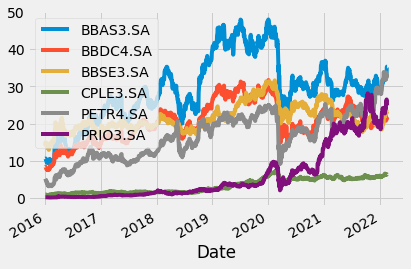

In [138]:
acoes = ['PRIO3.SA', 'BBAS3.SA', 'CPLE3.SA', 'BBDC4.SA', 'BBSE3.SA', 'PETR4.SA']
data_inicial = '2016-01-01'
data_final = '2022-02-18'
selic = 0.00915


for acao in acoes:
  table = yfinance.download(acoes, start=data_inicial, end=data_final)['Adj Close']

print(table.head())
table.plot()

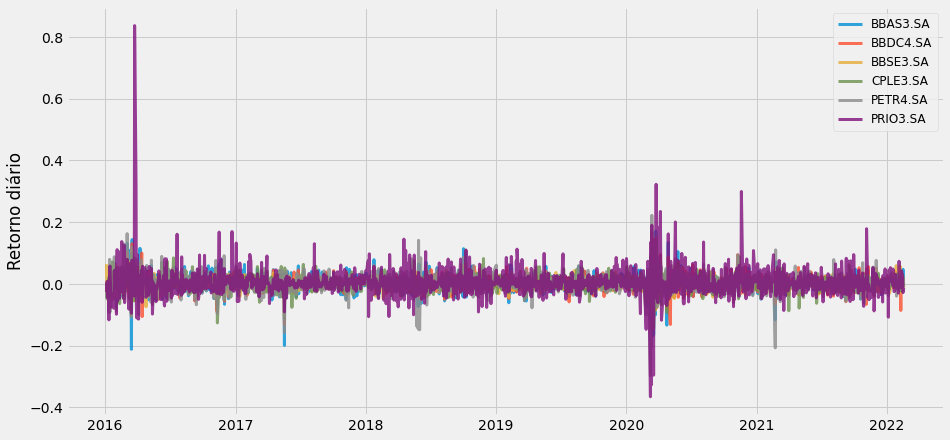

In [139]:
retornos = table.pct_change()

plt.figure(figsize=(14, 7))
for c in retornos.columns.values:
    plt.plot(retornos.index, retornos[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Retorno diário')
plt.show()

In [122]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
    

In [123]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(acoes))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [140]:
retornos = table.pct_change()
mean_returns = retornos.mean()
cov_matrix = retornos.cov()
num_portfolios = 25000
risk_free_rate = selic

In [142]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.66
Annualised Volatility: 0.43


            BBAS3.SA  BBDC4.SA  BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
allocation      1.18      0.66      3.75     47.65       3.7     43.07
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.24
Annualised Volatility: 0.28


            BBAS3.SA  BBDC4.SA  BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
allocation      2.68      3.34      56.4     35.15      0.78      1.65


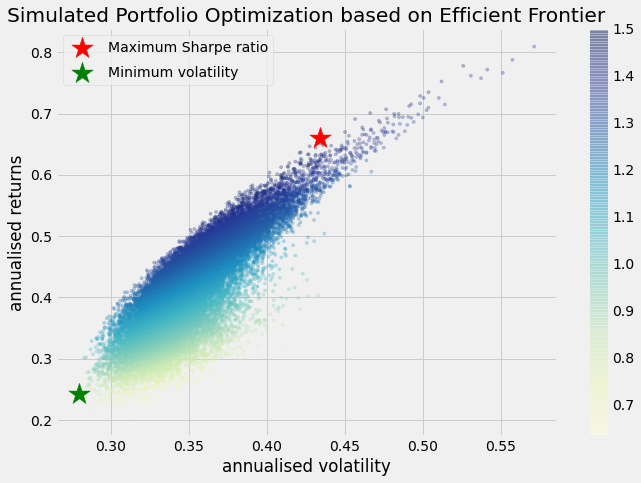

In [143]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [144]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [145]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [146]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [147]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.68
Annualised Volatility: 0.45


            BBAS3.SA  BBDC4.SA  BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
allocation       0.0       0.0       0.0     52.94      2.23     44.83
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.24
Annualised Volatility: 0.28


            BBAS3.SA  BBDC4.SA  BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
allocation       0.0      8.33     60.75     27.66       0.0      3.26


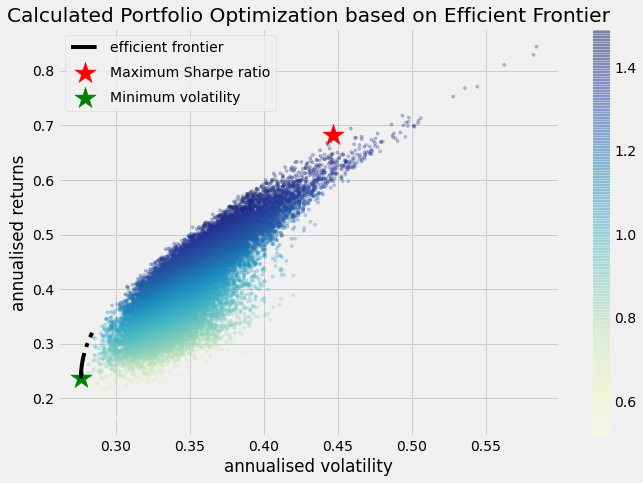

In [148]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [149]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(retornos) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print(txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.68
Annualised Volatility: 0.45


            BBAS3.SA  BBDC4.SA  BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
allocation       0.0       0.0       0.0     52.94      2.23     44.83
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.24
Annualised Volatility: 0.28


            BBAS3.SA  BBDC4.SA  BBSE3.SA  CPLE3.SA  PETR4.SA  PRIO3.SA
allocation       0.0      8.33     60.75     27.66       0.0      3.26
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

BBAS3.SA : annuaised return 0.3 , annualised volatility: 0.44
BBDC4.SA : annuaised return 0.22 , annualised volatility: 0.38
BBSE3.SA : annuaised return 0.13 , annualised volatility: 0.3
CPLE3.SA : annuaised return 0.38 , annualised volatil

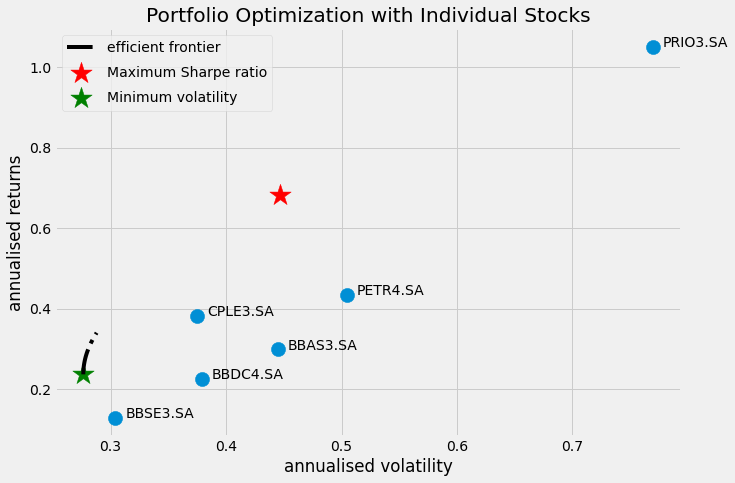

In [150]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)
